In [0]:
import requests
import pandas as pd
from time import time, mktime
import datetime
import numpy as np
import json
from math import cos, sqrt
from operator import itemgetter
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
# defining route and date for get requests
route_id = '1'
date = '2020-06-01'

# route and location info from api, stops from Labs22
stops_url = 'https://raw.githubusercontent.com/Lambda-School-Labs/sfmta-data-analysis-ds/master/deprecated_assets/datasets/route_info.csv'
schedules_url = 'http://sfmta-ds.eba-hqpuyrup.us-east-1.elasticbeanstalk.com/get-route-info' # needs to be updated with api url when live
daily_url = 'http://sfmta-ds.eba-hqpuyrup.us-east-1.elasticbeanstalk.com/daily-general-json'

stops = pd.read_csv(stops_url)
sched_json = requests.get(schedules_url, params={'route_id': route_id,
                                                 'day': date}).json()
daily_json = requests.get(daily_url, params={'day': date}).json()

# First Look At Calculating Bunches & Gaps

## Helper Functions

In [0]:
def fcc_projection(loc1, loc2):
    """
    function to apply FCC recommended formulae
    for calculating distances on earth projected to a plane
    
    significantly faster computationally, negligible loss in accuracy
    
    Args: 
    loc1 - a tuple of lat/lon
    loc2 - a tuple of lat/lon
    """
    lat1, lat2 = loc1[0], loc2[0]
    lon1, lon2 = loc1[1], loc2[1]
    
    mean_lat = (lat1+lat2)/2
    delta_lat = lat2 - lat1
    delta_lon = lon2 - lon1
    
    k1 = 111.13209 - 0.56605*cos(2*mean_lat) + .0012*cos(4*mean_lat)
    k2 = 111.41513*cos(mean_lat) - 0.09455*cos(3*mean_lat) + 0.00012*cos(5*mean_lat)
    
    distance = sqrt((k1*delta_lat)**2 + (k2*delta_lon)**2)
    
    return distance

In [0]:
def get_dwell(df):    
    dwell_count = 0
    dwell_totals = []

    for x in df['kph']:
        if x <= 0:
          dwell_count += 1
          dwell_totals.append(dwell_count)
        elif x > 0:
          dwell_totals.append(0)
          dwell_count = 0
            
    df['dwell'] = [dwell_totals[x] for x in range(len(df))]

    return df

In [0]:
def adjust_timestamp(df):
    times = df.timestamp.values
    ages = df.age.values

    df['adjusted_timestamp'] = [pd.Timestamp(times[x]) - 
                                pd.Timedelta(seconds=ages[x]) 
                                for x in range(len(df.timestamp))]
    
    return df

In [0]:
def assign_stops(df, stops):
    """
    applies basic wrangling function
    calculates nearest stop from reported location in km
    returns dataframe with reported location, 
    nearest stop (coords and name), and distance between
    
    implements FCC projection formulae for calculating distance
    
    Args:
    df - dataframe of transit data, requires 'latitude', 'longitude' columns
    stops - datafram of stops data, requires 'lat', 'lon', 'title' columns
    """
    
    stop_lats = stops['lat'].values
    stop_lons = stops['lon'].values

    reported_lats = df['latitude'].values
    reported_lons = df['longitude'].values

    stop_points = [{'latitude': stop_lats[x], 'longitude': stop_lons[x]} 
                 for x in range(len(stops))]

    reported_points = [{'latitude': reported_lats[x], 
                      'longitude': reported_lons[x]} 
                     for x in range(len(df))]

    radius = .1524

    stop_point_tuples = [tuple(stop_points[x].values()) 
                       for x in range(len(stop_points))]

    reported_point_tuples = [tuple(reported_points[x].values()) 
                           for x in range(len(reported_points))]

    df['reported_location'] = reported_point_tuples
        
    distances = [{x: fcc_projection(location, x) 
                 for x in stop_point_tuples} 
                 for location in reported_point_tuples]
        
    distances_sorted = [{k: v for k, v in sorted(distances[x].items(), 
                                                 key=itemgetter(1))}
                       for x in range(len(distances))]
        
    point_stops = [next(iter(distances_sorted[x].items())) 
                   if next(iter(distances_sorted[x].items()))[1] <= radius 
                   else None
                   for x in range(len(distances_sorted))]
 
    stop_tuples = list(zip(stops.lat, stops.lon))
    stop_titles = [stops.title.iloc[stop_tuples.index(stop[0])] 
                   if stop != None
                   else None 
                   for stop in point_stops]
        
    df['nearest_stop'] = [x[0] if x != None else None for x in point_stops]
    df['distance_in_km'] = [x[1] if x != None else None for x in point_stops]

    df['title'] = stop_titles

    df = df.drop(columns=['age', 'rid', 'latitude', 'longitude', 'timestamp',
                          'heading'])
    
    return df

In [0]:
def bin_from_timestamp(timestamp, bins):
    diffs = [abs(timestamp - x) for x in bins]
    return bins[diffs.index(min(diffs))]

## Function To Calculate B&Gs

In [0]:
def find_disruptions(stops, daily_json, schedules_json):
    
    start = time()

    # pulling relevant info from schedules_json
    route = schedules_json['route']
    intervals = schedules_json['intervals']
    stop_list = schedules_json['stops']

    # filtering by route    
    locations = pd.DataFrame(data=daily_json).dropna()
    locations = locations[locations.rid.eq(route)]
    
    # unifying direction tags for later merging
    locations['direction'] = ['Inbound' if '_I' in x 
                              else 'Outbound' if '_O' in x
                              else None
                              for x in locations.direction.values]
    
    # filtering by route and current active stops
    stops = stops[stops.route_id.eq(route)]
    stops = stops[stops.tag.isin(stop_list)]
    stops = stops.rename(columns={'dir': 'direction'})

    print(f'Prep Complete: {time()-start} Seconds')
    
    # adjusting timestamps
    locations = adjust_timestamp(locations)

    print(f'Timestamps Adjusted: {time()-start} Seconds')

    # calculating dwell time for filtering
    locations = get_dwell(locations)

    print(f'Dwell Calculated: {time()-start} Seconds')
    
    # calculating nearest stops and distances
    locations = assign_stops(locations, stops)

    print(f'Stops Assigned: {time()-start} Seconds')
    
    # merging to assign titles to stops and unify tags
    locations = locations.merge(stops[stops.route_id.eq(route)], 
                                how='left', on=['direction', 'title'])
    
    locations = locations.drop(columns=[
                                        'route_id', 'lat', 
                                        'lon', 'stopId']).dropna()

    # dropping all reports with dwell != 0
    locations = locations[locations.dwell.eq(0)
                          ].reset_index(drop=True
                                        ).sort_values('adjusted_timestamp')
    
    print(f'Stops Filtered: {time()-start} Seconds')

    # separating by stop to calculate service deltas and disruptions
    stop_dfs = []
    for x in locations.tag.unique():
      
        df = locations[locations.tag.eq(x)].copy().reset_index(drop=True)

        df['window'] = [round((locations.loc[x, 'distance_in_km'] / 
                                      np.mean(df.kph))*3600, 2) 
                              for x in range(len(df))]

        df['service_deltas'] = [pd.Timestamp(df.loc[x, 'adjusted_timestamp']) 
                                            - pd.Timestamp(df
                                            .loc[x-1,  'adjusted_timestamp'])
                                            if x != 0
                                            else None
                                            for x in range(len(df))]
        
        df['adjusted_service_deltas'] = [(df.loc[x, 'service_deltas'].total_seconds()
                                        - pd.Timedelta(seconds=df.loc[x, 'window']).total_seconds(),
                                        df.loc[x, 'service_deltas'].total_seconds()
                                        + pd.Timedelta(seconds=df.loc[x, 'window']).total_seconds())
                                        for x in range(len(df))]
        
        df['service_disruptions'] = [1 if (x[0]/60) < .2 * intervals['mode']
                                            else -1 if (x[1]/60) > 1.5 * intervals['mode']
                                            else 0
                                            for x in df['adjusted_service_deltas']]
        
        # dropping instances of multiple identical reports
        df.drop_duplicates(subset=['vid', 'adjusted_timestamp'], 
                          keep='first', inplace=True)
        
        # creating new dataframe of timestamp / stop: service_disruptions
        df = pd.DataFrame(data={'adjusted_timestamp': df.adjusted_timestamp.values,
                                f'{x}': df.service_disruptions.values})

        stop_dfs.append(df)
    
    print(f'Services Analyzed: {time()-start} Seconds')
    
    # merging all stop-level dataframes
    # result is df of columns: stops, rows: timestamps, cells: B&Gs
    daily_service = reduce(lambda x, y: pd.merge(x, y, 
                                               on='adjusted_timestamp', 
                                               how='outer', sort=True), 
                                               stop_dfs)
    
    print(f'Master DataFrame Compiled: {time()-start} Seconds')

    # Forward fill of service                               
    daily_service.fillna(method='ffill', inplace=True, axis=0)
    
    print(f'Naive Service Imputation Complete: {time()-start} Seconds')

    # creating a simple filter for calculating metrics
    stop_columns = daily_service.copy().columns
    
    # calculating basic metrics
    daily_service['on_time'] = daily_service[stop_columns].eq(0).sum(axis=1)
    daily_service['bunches'] = daily_service[stop_columns].eq(1).sum(axis=1)
    daily_service['gaps'] = daily_service[stop_columns].eq(-1).sum(axis=1)
    daily_service['service_disruptions'] = daily_service[['bunches', 
                                                            'gaps']].sum(axis=1)

    daily_service['coverage'] = [round((x['on_time'] + x['bunches']) / 
                                           (x['bunches'] + x['on_time'] 
                                            + x['gaps']
                                            ) * 100, 2) 
                                  for _, x in daily_service.iterrows()]
    
    daily_service['on_time_%'] = [round(x['on_time'] / 
                                            (x['on_time'] + 
                                            x['service_disruptions']
                                             ) * 100, 2)
                                  for _, x in daily_service.iterrows()]
    
    average_coverage = np.mean(daily_service.coverage)
    average_on_time = np.mean(daily_service['on_time_%'])
    total_bunches = daily_service.bunches.sum()
    total_gaps = daily_service.gaps.sum()
    total_disruptions = daily_service.service_disruptions.sum()
    total_on_time = daily_service.on_time.sum()
    total_services = (daily_service.on_time.sum() +
                            daily_service.service_disruptions.sum())

    
    print(f'Metrics Calculated - Total Time: {time()-start} Seconds')
            
    return {'dataframe': daily_service, 
            'metrics': {'coverage': average_coverage,
                        'on_time_%': average_on_time,
                        'totals': {'bunches': total_bunches,
                                   'gaps': total_gaps,
                                   'disruptions': total_disruptions,
                                   'on_time': total_on_time,
                                   'services': total_services}}}

In [552]:
output = find_disruptions(stops, daily_json, sched_json)
daily_service = output['dataframe']

Prep Complete: 0.6126761436462402 Seconds
Timestamps Adjusted: 0.9255528450012207 Seconds
Dwell Calculated: 0.9312446117401123 Seconds
Stops Assigned: 1.7302463054656982 Seconds
Stops Filtered: 1.7505877017974854 Seconds
Services Analyzed: 2.103181838989258 Seconds
Master DataFrame Compiled: 2.187445640563965 Seconds
Naive Service Imputation Complete: 2.189103603363037 Seconds
Metrics Calculated - Total Time: 2.478125810623169 Seconds


In [553]:
output['metrics']

{'coverage': 44.532984031936294,
 'on_time_%': 33.92160678642728,
 'totals': {'bunches': 1799,
  'disruptions': 11224,
  'gaps': 9425,
  'on_time': 5555,
  'services': 16779}}

In [541]:
daily_service.head(5)

,adjusted_timestamp,4026.0,4028.0,4015.0,4027.0,3825.0,6314.0,6312.0,3893.0,3848.0,6296.0,34015.0,6311.0,4277.0,3892.0,34277.0,3824.0,6295.0,on_time,bunches,gaps,service_disruptions,coverage,on_time_%
0,2020-06-01 03:42:13,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,100.0,100.0
1,2020-06-01 03:47:30,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,100.0,100.0
2,2020-06-01 03:49:56,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0,0,0,100.0,100.0
3,2020-06-01 03:51:59,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,100.0,100.0
4,2020-06-01 04:02:27,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,0,0,0,100.0,100.0


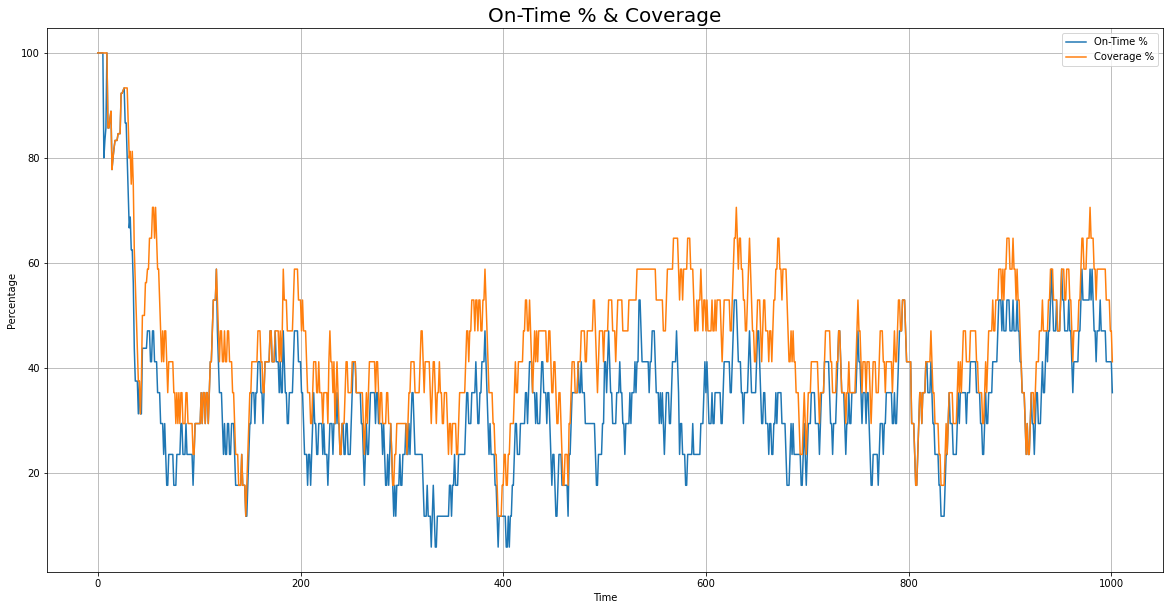

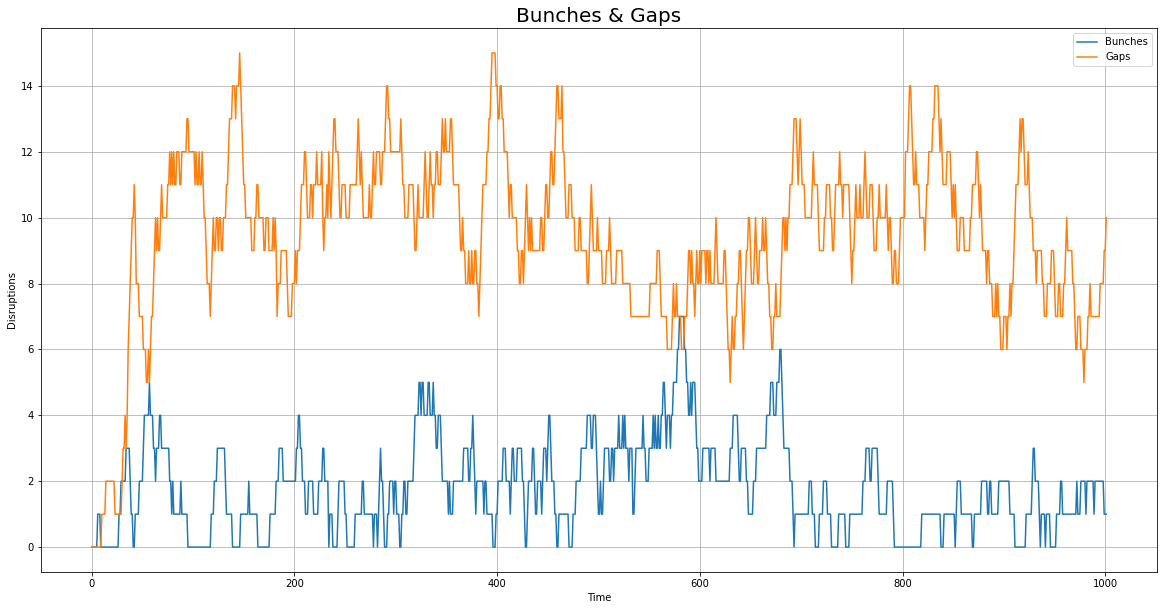

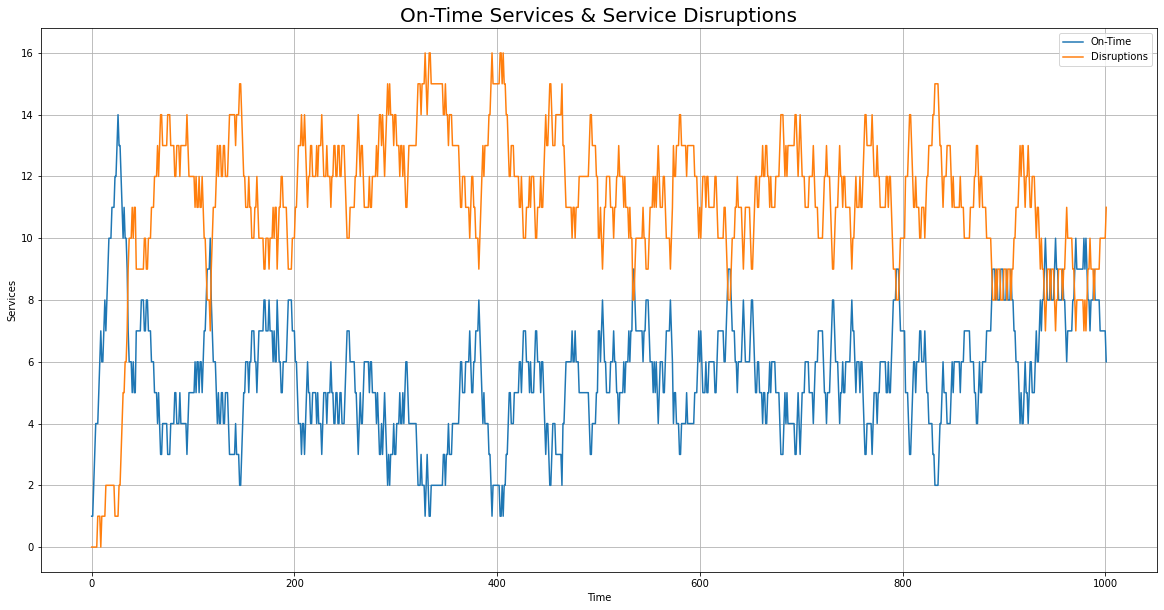

In [535]:
fig, ax = plt.subplots()

sns.lineplot(x=daily_service.index, y=daily_service['on_time_%'])
sns.lineplot(x=daily_service.index, y=daily_service.coverage)

ax.legend(['On-Time %', 'Coverage %'])
ax.grid()
fig.set_size_inches(20, 10)
plt.title('On-Time % & Coverage', {'fontsize': 20})
plt.ylabel('Percentage')
plt.xlabel('Time')
plt.show()

fig, ax = plt.subplots()

sns.lineplot(x=daily_service.index, y=daily_service.bunches)
sns.lineplot(x=daily_service.index, y=daily_service.gaps)

ax.legend(['Bunches', 'Gaps'])
ax.grid()
fig.set_size_inches(20, 10)
plt.title('Bunches & Gaps', {'fontsize': 20})
plt.ylabel('Disruptions')
plt.xlabel('Time')
plt.show()

fig, ax = plt.subplots()

sns.lineplot(x=daily_service.index, y=daily_service.on_time)
sns.lineplot(x=daily_service.index, y=daily_service.service_disruptions)

ax.legend(['On-Time', 'Disruptions'])
ax.grid()
fig.set_size_inches(20, 10)
plt.title('On-Time Services & Service Disruptions', {'fontsize': 20})
plt.ylabel('Services')
plt.xlabel('Time')
plt.show();

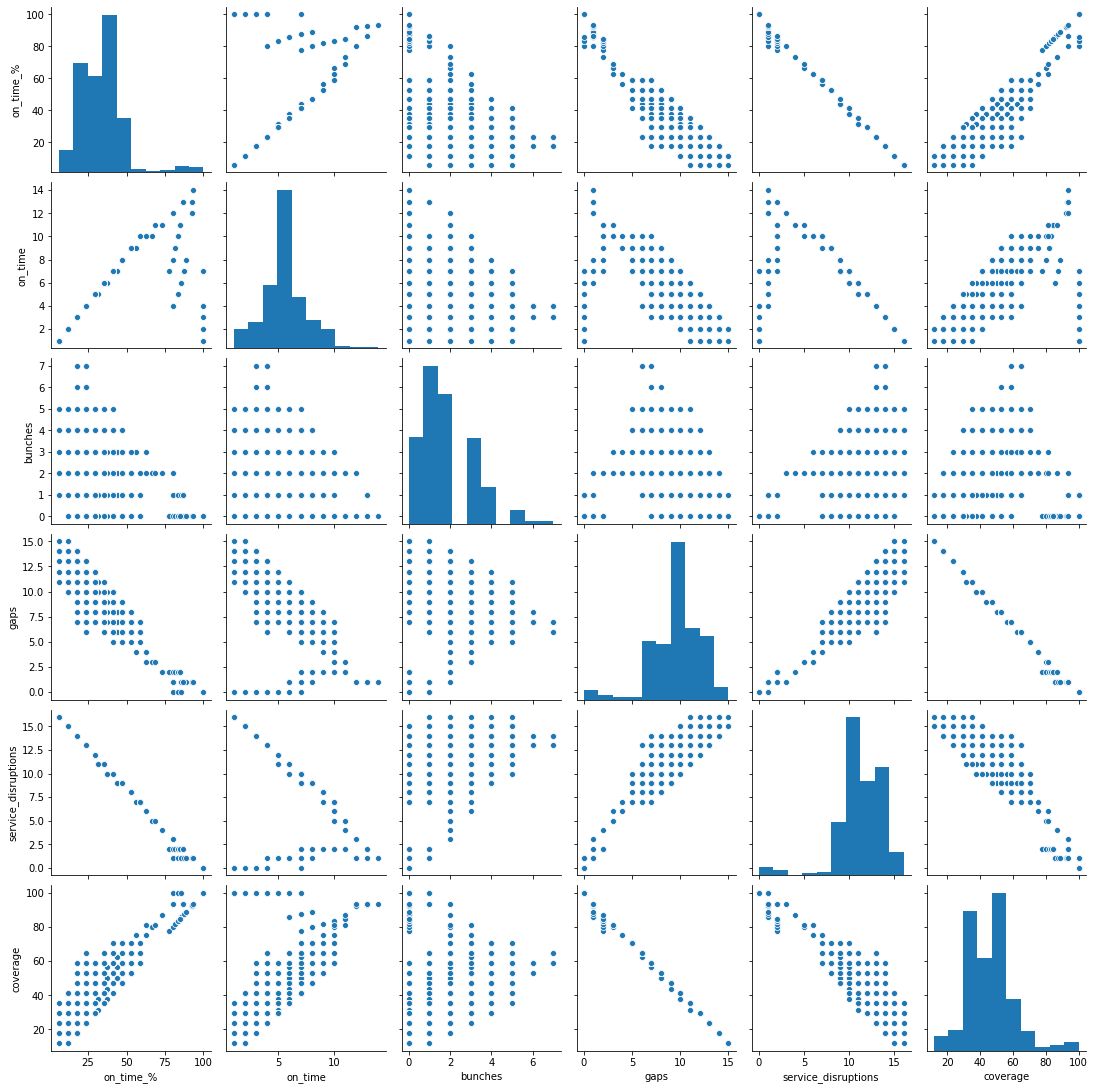

In [536]:
sns.pairplot(data=daily_service[['on_time_%', 'on_time', 'bunches', 
                               'gaps', 'service_disruptions', 'coverage']]);

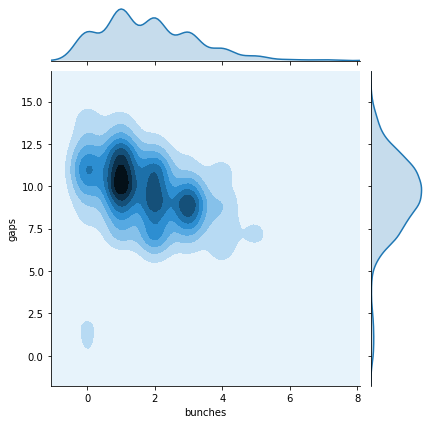

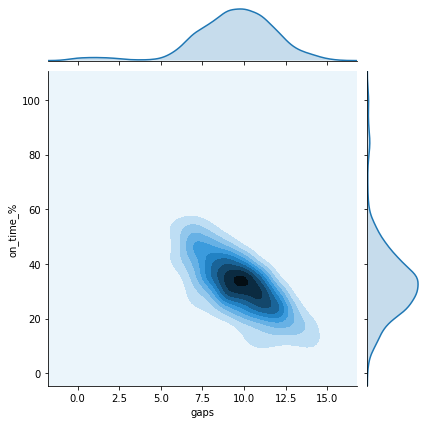

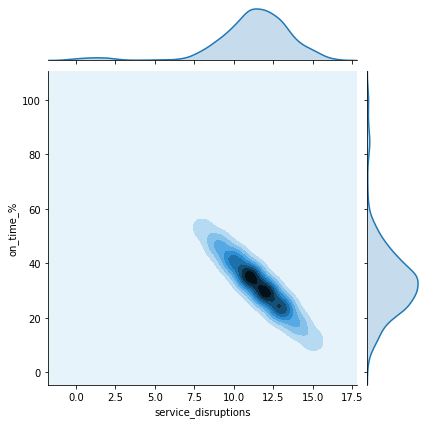

In [537]:
sns.jointplot(daily_service.bunches, 
              daily_service.gaps, 
              kind='kde')

sns.jointplot(daily_service.gaps, 
              daily_service['on_time_%'], 
              kind='kde')

sns.jointplot(daily_service.service_disruptions, 
              daily_service['on_time_%'], 
              kind='kde');

# Results

Right off the bat, it's important to note that this is far from a perfect, precise approach. I've made a lot of assumptions and simplifications for the sake of time and ease, namely:
- Dwell-time reported at a stop shouldn't be used to determine bunching/\
gapping; we're concerned with headway *between* busses, not necessarily the progress of a single bus

- Rather than trying to calculate exactly when a bus was at a stop, I've based my bunches and gaps off of a *window* of time calculated as the time since a stop was last serviced $T$ plus or minus the reported distance from the stop $\Delta$ divided by the average kph for that route $v$

\begin{equation}
  w = T \pm (\Delta \div v)
\end{equation}

- If the lower bound of $w$ is below 20% of the common scheduled headway $h$, that stop registers a bunch ($s=1$) at that time; else if the upper bound of $w$ is above 150% of $h$, that stop registers a gap ($s=-1$) at that time; if stop isn't bunched or gapped we register an "on-time" service ($s=0$).

\begin{equation}
  s=\begin{cases}
    1, & \text{if $w<0.2 \cdot h$}.\\
    -1, & \text{if $w>1.5 \cdot h$}.\\
    0, & \text{otherwise.}
  \end{cases}
\end{equation}

- State is calculated for every service at a given stop and assumed to persist until a subsequent service alters that state

- Rather than dealing with a largely empty dataframe, we are dealing only with timestamps for which there was a recorded service for at least one stop in the line; every row contains at least one "true" observation alongside the "assumed" observations, and our number of observations is limited by the number of "true" observations across unique timestamps

- Stops are (temporarily) being pulled from the Labs22 data for my own ease and speed in writing; code should plug-and-play with similarly formatted but up-to-date data

I'm calculating coverage at a given timestamp $C$ as on-time services $s_0$ at that time plus bunched services $s_1$ at that time, divided by total services $s_t$ at that time

\begin{equation}
  C = \frac{s_0 + s_1}{s_t}
\end{equation}

And on-time frequency at a given timestamp $f$ simply as on-time services $s_0$ divided by total services $s_t$

\begin{equation}
  f = \frac{s_0}{s_t}
\end{equation}

The end result of all of this is that we do have actual metrics and visualizations that at least *approximate* the actual health of the system. 

By no means would I imagine this to particularly accurate, but it should be good enough to provide more and better insight than a random guess. 

**All models are wrong, but some are useful.**

¯\\_(ツ)_/¯